# Plant and author distributions
Code to generate figure demonstrating the relationship between desiccation plant distribution and author locations.

In [15]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm
from collections import defaultdict
import plotly.express as px
import pycountry
import numpy as np
import jsonlines
import sys
sys.path.append('../desiccation_network/conference_recommendation/')
import utils

## Read in data

In [16]:
attendees_2016 = pd.read_csv('../data/conference_data/attendees_2016.csv')
attendees_2024 = pd.read_csv('../data/conference_data/attendees_2024.csv')

In [17]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_ALL_with_authors_and_addresses_14Feb2024.jsonl') as reader:
    all_papers = [obj for obj in reader]

In [18]:
for col in attendees_2016.columns:
    attendees_2016[col] = attendees_2016[col].str.strip()
for col in attendees_2024.columns:
    attendees_2024[col] = attendees_2024[col].str.strip()

In [19]:
spec_occ = pd.read_csv('../data/conference_data/species_occ.csv', encoding_errors='replace')
spec_occ.head()

,sp_id,institutionCode,catalogNumber,countryCode,decimalLongitude,decimalLatitude,source
0,aaa023,PERTH,PERTH 3249093,AUS,116.083333,-34.766667,https://www.gbif.org/
1,aaa023,PERTH,PERTH 5453119,AUS,117.270833,-34.851389,https://www.gbif.org/
2,aaa023,PERTH,PERTH 6905811,AUS,117.016667,-34.516667,https://www.gbif.org/
3,aaa023,PERTH,PERTH 5900085,AUS,115.083333,-33.750000,https://www.gbif.org/
4,aaa023,PERTH,PERTH 3248895,AUS,115.938056,-34.508056,https://www.gbif.org/


In [20]:
spec_names = pd.read_csv('../data/conference_data/species_list.csv', encoding_errors='replace')
spec_names.head()

,sp_id,Family,Species,Taxonomic authority,Taxonomic observations,Cited as DT by
0,aaf003,Anemiaceae,Anemia ferruginea,Kunth,NaN,Ibisch et al. (1995)
1,aaf019,Anemiaceae,Anemia flexuosa,(Savigny) Sw.,NaN,Meirelles et al. (1997)
2,aax231,Anemiaceae,Anemia mexicana,Klotzsch,NaN,"Kessler & Siorak (2007), Mkhize (2018)"
3,aar329,Anemiaceae,Anemia rotundifolia,Schrad.,NaN,"Kessler & Siorak (2007), Derzhavina (2017), Mk..."
4,aat020,Anemiaceae,Anemia tomentosa,(Savigny) Sw.,NaN,"Gaff (1987), Kessler & Siorak (2007), Hietz (2..."


## Basic visualizations

### Number of observations per species

<Axes: xlabel='decimalLongitude', ylabel='Density'>

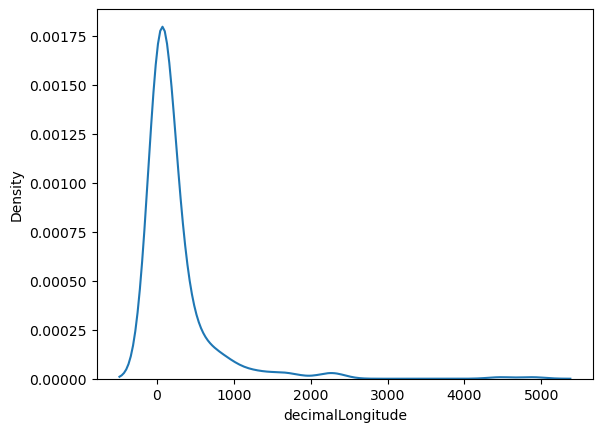

In [21]:
sns.kdeplot(spec_occ.groupby('sp_id').count()['decimalLongitude'])

### All individual plant observations

/tmp/local/31566388/ipykernel_65672/1447024440.py:4: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

ERROR 1: PROJ: proj_create_from_database: Open of /mnt/home/lotrecks/anaconda3/envs/graphs/share/proj failed


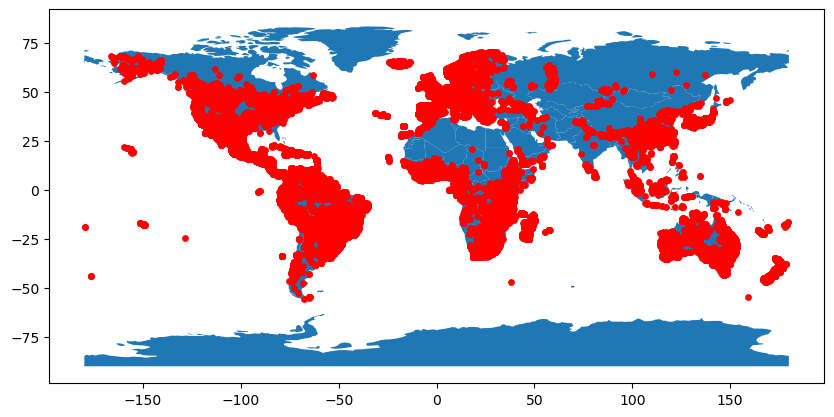

In [22]:
geometry = [Point(xy) for xy in zip(spec_occ['decimalLongitude'], spec_occ['decimalLatitude'])]
gdf = GeoDataFrame(spec_occ[['decimalLatitude', 'decimalLongitude']], geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

### Number of conference authors per country

Merge attendee lists:

In [23]:
attendees = attendees_2016.merge(attendees_2024, on=['Surname', 'First_name', 'Affiliation', 'Country'], how='outer', suffixes=('_2016', '_2024')).drop_duplicates(ignore_index=True)
attendees.head()

,Surname,First_name,Affiliation,Country
0,Barak,Simon,Ben-Gurion University of the Negev,Israel
1,Bar-Eyal,Leeat,The Hebrew University of Jerusalem,Israel
2,Bentley,Joanne,University of Cape Town,South Africa
3,Bharuth,Vishal,University of KwaZulu Natal,South Africa
4,Borner,Andreas,Leibniz Institute of Plant Genetics & Crop Pla...,Germany


In [24]:
unique_attendees = attendees.drop_duplicates(subset=['Surname', 'First_name'], ignore_index=True).sort_values('Surname')

In [25]:
unique_attendees.Country.unique()

array(['Netherlands', 'Uganda', 'Israel', 'South Africa', 'United States',
       'Germany', 'Brazil', 'France', 'New Zealand', 'India', 'Poland',
       'China', 'The Netherlands', 'Ethiopia', 'Austria', 'Spain',
       'Italy', 'Kenya', 'USA', 'Australia', 'Bulgaria', 'Japan'],
      dtype=object)

In [26]:
unique_attendees = unique_attendees.replace({'The Netherlands': 'Netherlands', 'USA': 'United States'})

Get the country codes for all countries:

In [27]:
country_conversions = {country.name: country.alpha_3 for country in pycountry.countries}

In [28]:
country_counts = pd.DataFrame(unique_attendees['Country'].value_counts(), columns=['count'])
country_counts['iso_alpha'] = country_counts.index.map(country_conversions)
country_counts.head()

,count,iso_alpha
Country,,
South Africa,38,ZAF
United States,15,USA
Israel,8,ISR
Netherlands,7,NLD
Germany,7,DEU


In [29]:
country_conv_df = pd.DataFrame.from_dict(country_conversions, orient='index', columns=['iso_alpha'])
country_conv_df['count'] = 0
country_conv_df.index.name = 'Country'
country_counts = country_conv_df.merge(country_counts, on=['Country', 'iso_alpha'], how='outer').drop(columns=['count_x']).rename(columns={'count_y': 'count'})
country_counts.head()

,iso_alpha,count
Country,,
Aruba,ABW,NaN
Afghanistan,AFG,NaN
Angola,AGO,NaN
Anguilla,AIA,NaN
Åland Islands,ALA,NaN


Make plot:

In [30]:
fig = px.choropleth(country_counts, locations='iso_alpha', color='count', color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

### Unique plant observations per country

First, we need to map each set of coordinates to a country:

In [31]:
latlons = defaultdict(list)
for i, row in spec_occ.iterrows():
    latlons[row['sp_id']].append((row['decimalLatitude'], row['decimalLongitude']))
latlons = {k: list(set(v)) for k, v in latlons.items()}

In [32]:
print(f'There are {sum([len(v) for v in latlons.values()])} total observations, {len(set([coords for v in latlons.values() for coords in v]))} of them are unique.')

There are 61457 total observations, 48417 of them are unique.


In [33]:
unique_coords = list(set([coords for v in latlons.values() for coords in v]))

Given the large volume of coordinates, this mapping procedure is quite time consuming (~7h for all unique coordinates). Therefore, we'll submit the following code as a job:

In [34]:
# geolocator = Nominatim(user_agent="desiccation")

In [35]:
# observation_countries = {}
# for coord in tqdm(unique_coords):
#     address = geolocator.reverse(coord)
#     country = address.raw['address']['country']
#     observation_countries[coord] = country

In [36]:
# coords_country_df = pd.read_csv()

### Combining conference attendance with plant distribution
We want to plot conference attendance as circles, and color countries by the number of unique resurrection plants they have.

### Number of desiccation tolerance authors
We want to produce the same plot as above but for all authors in our dataset.

First, we need to process the authors and addresses from all papers in the dataset. For the purposes of this exercise, we will assume anyone with the same WOS standard name is the same person.

In [49]:
author_affils = utils.get_geographic_locations(all_papers)

There are 11637 author-country pairs, and 18036 total authors.


In [50]:
author_affils_df = pd.DataFrame.from_dict(author_affils, orient='index', columns=['iso_alpha'])

In [51]:
all_author_country_counts = author_affils_df.value_counts().reset_index()

In [40]:
fig = px.choropleth(all_author_country_counts, locations='iso_alpha', color='count', color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

Will want to normalize this plot by various factors -- research funding, total publications per country, etc.

#### Unknown location probability
We want to have a way to assign some kind of score to authors that don't have a location recorded in our dataset. To do that, let's calculate the probability that an author of unknown origin belongs to one of the attendee countries. We'll assume that the overall author distribution follows the distribution of recorded authors, and that the weight of each country in that distribution determines the probability that a random author belongs there.

In [52]:
country_weights = all_author_country_counts['count']/sum(all_author_country_counts['count'])

In [54]:
attendee_countries = country_counts[~country_counts['count'].isna()]['iso_alpha']
attendee_country_idxs = all_author_country_counts[all_author_country_counts['iso_alpha'].isin(attendee_countries)]
attendee_counries_total_weight = country_weights.loc[attendee_country_idxs.index].sum() 

In [62]:
print(f'There is a {attendee_counries_total_weight*100:.2f}% probability that a given author is from an attendee country.')

There is a 72.96% probability that a given author is from an attendee country.


In [78]:
split_50p = np.percentile(country_counts['count'].dropna(), 50)
top_50p = country_counts[country_counts['count'] >= split_50p]['iso_alpha'].tolist()
bottom_50p = country_counts[country_counts['count'] < split_50p]['iso_alpha'].tolist()

In [82]:
attendee_country_num = len(country_counts[~country_counts["count"].isna()])

In [83]:
print(f'Of the total {attendee_country_num} attendee countries, {len(top_50p)} are high-representation countries, and {len(bottom_50p)} are low representation countries.')

Of the total 20 attendee countries, 13 are high-representation countries, and 7 are low representation countries.


In [84]:
high_prob = len(top_50p)/attendee_country_num
low_prob = len(bottom_50p)/attendee_country_num

In [87]:
low_prob

0.35

We want to express the following in a single numerical score:
>27% of the time, a random author will get a score of 1, and the rest of the time, 35% of the time they will get a score of 0.5, otherwise they get a 0.

We can extress this with the following equation:

$$0.27*1 + 0.73*(0.35*0.5)$$

Generalizing to our variables:

$$\text{non-attendee countries total weight} + \text{attendee countries total weight} * (\text{low representation probability} * 0.5)$$

The resulting number:

In [88]:
random_author_score = (1 - attendee_counries_total_weight) + (attendee_counries_total_weight*(low_prob*0.5))
random_author_score

0.3981051817478731

We'll round this to 0.4 for simplicity.

### Combining overall authors with plant distribution
